# **10. Estimación de fase cuántica (QPE)**

# **Dive in Learning**

# ***Diplomado en Computación y Programación Cuántica***

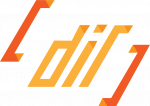

In [ ]:
!pip install qiskit --quiet
!pip install qiskit[visualization] --quiet
!pip install qiskit-aer --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 53.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 55.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 94.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
from math import sqrt, pi
import operator
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, transpile

# Visualizar los resultados
from qiskit.visualization import plot_histogram, plot_bloch_multivector

# **Algoritmo QPE**

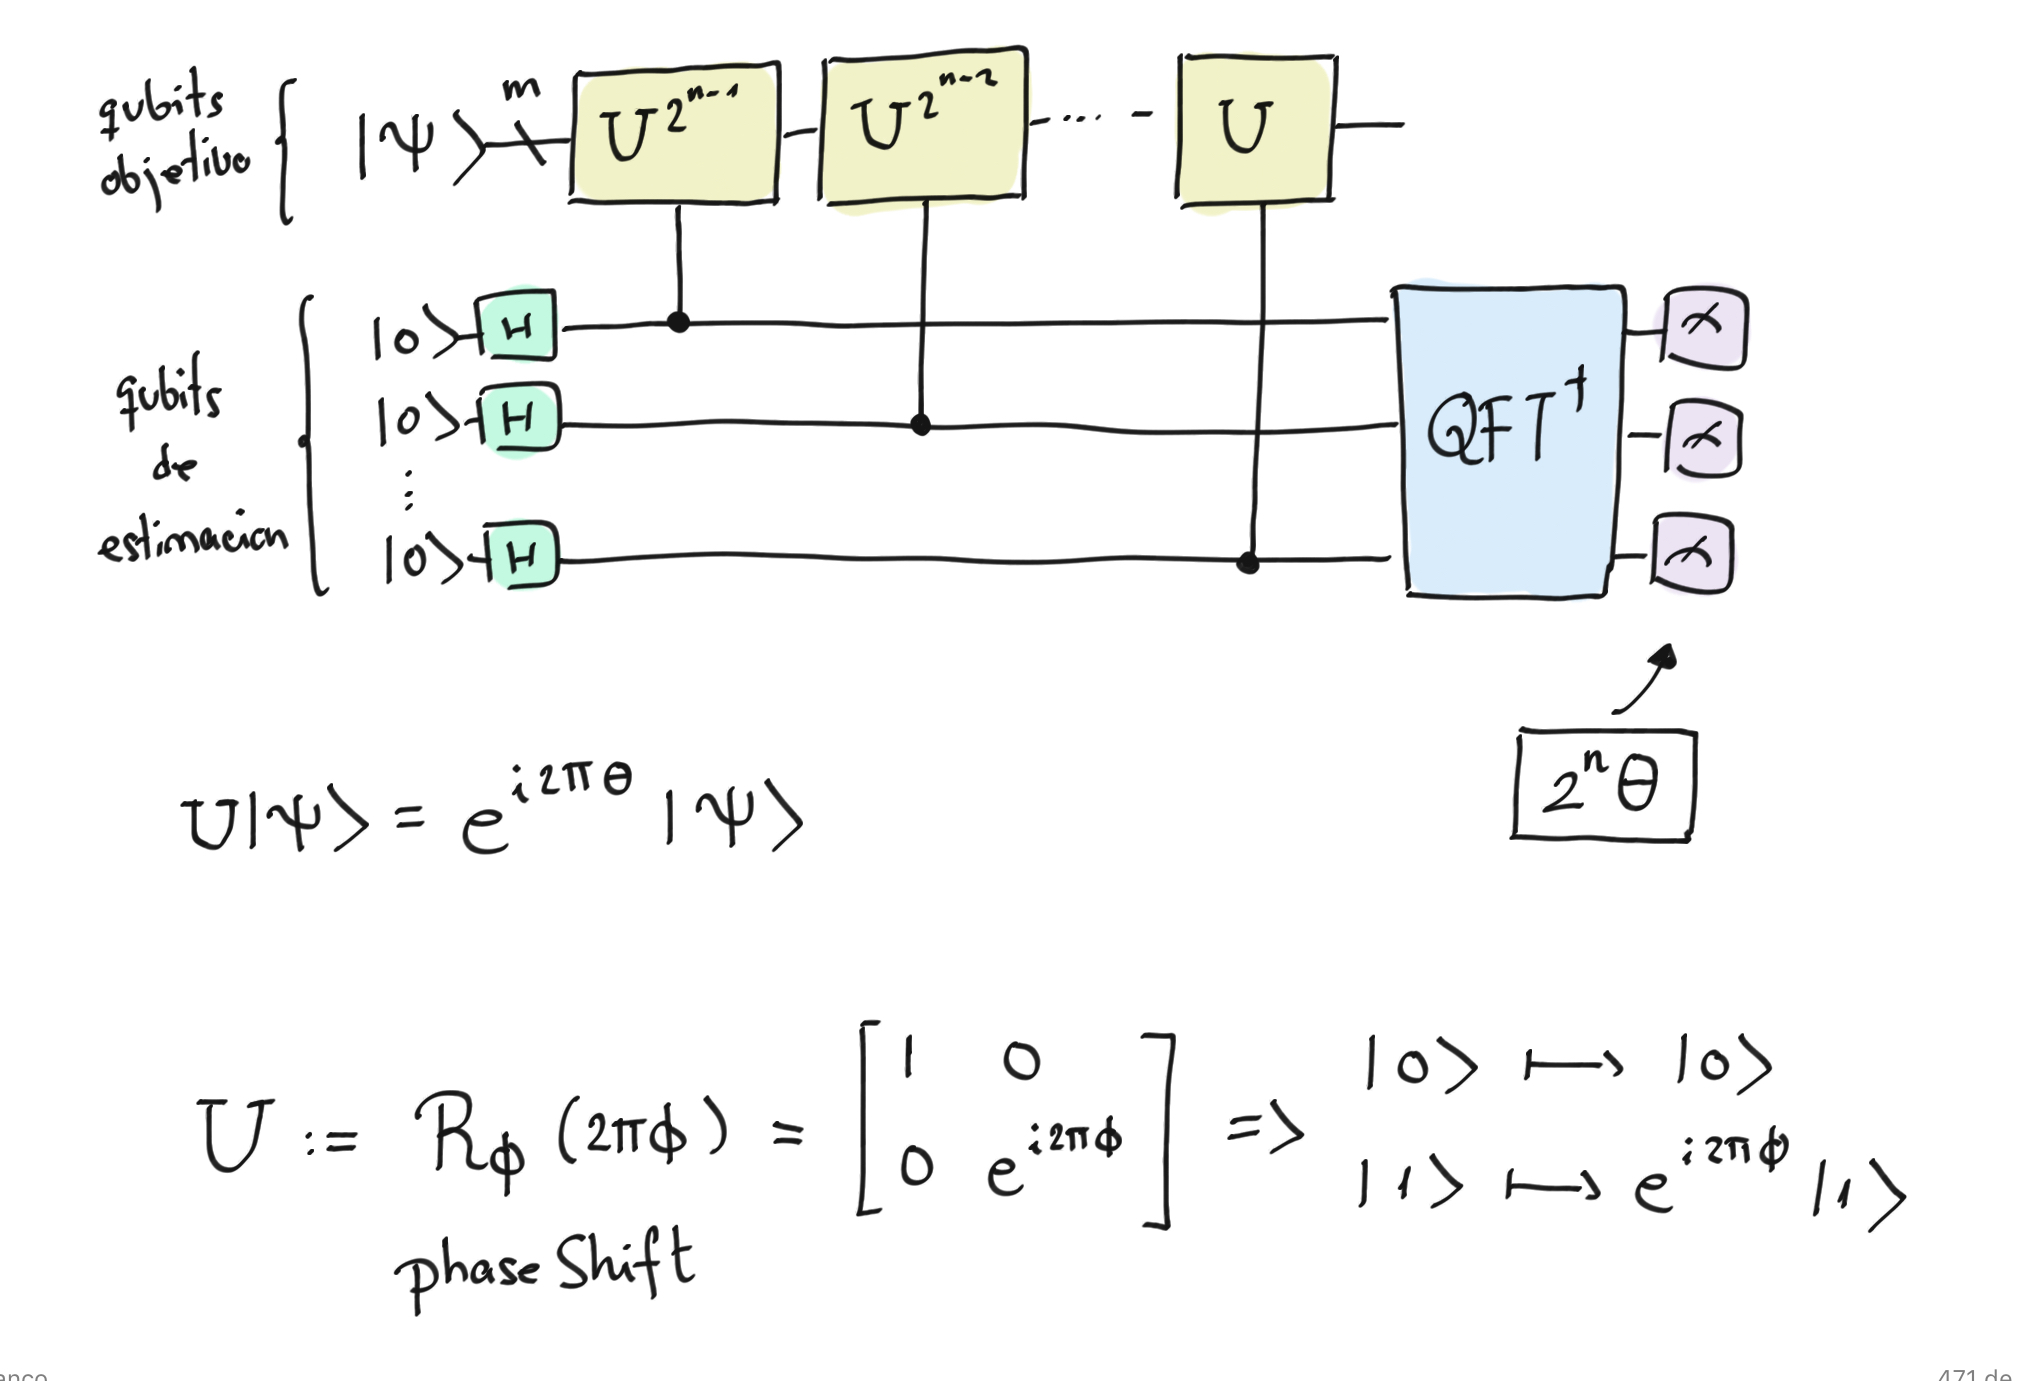

# **Implementación manual**

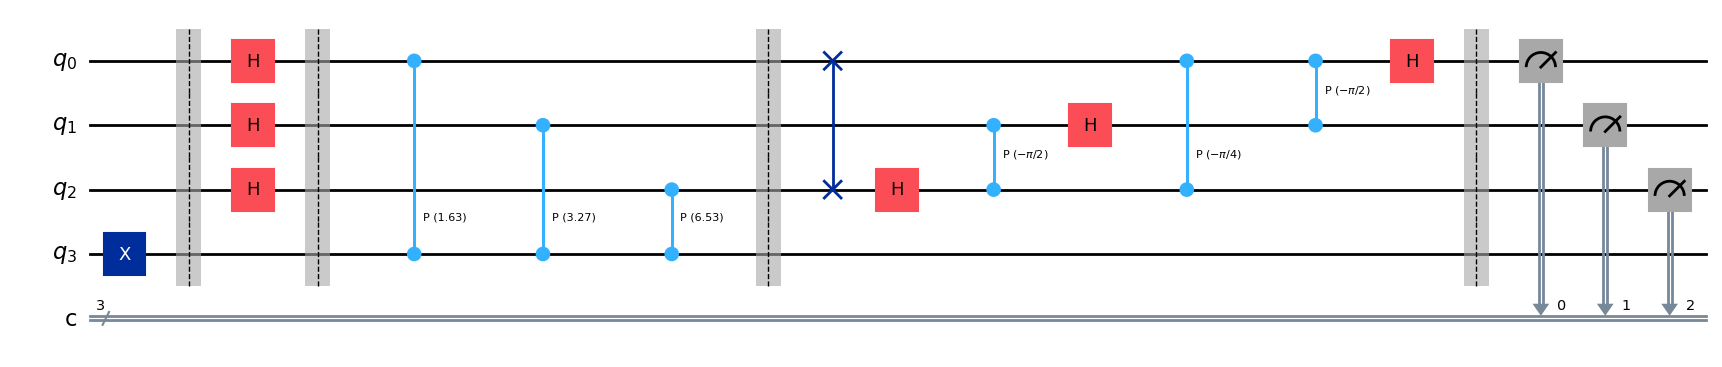

In [ ]:
angulo = 0.26

#Crear circuito
numero_qubits = 3
qubits_estado = 1
circ = QuantumCircuit(numero_qubits + qubits_estado, numero_qubits)

#Inicializando y agregando operaciones al circuito

circ.x(3)

circ.barrier()

circ.h(0)
circ.h(1)
circ.h(2)

circ.barrier()

circ.cp(2*pi*pow(2,0)*angulo,0,3)
circ.cp(2*pi*pow(2,1)*angulo,1,3)
circ.cp(2*pi*pow(2,2)*angulo,2,3)

circ.barrier()

circ.swap(0, 2)
circ.h(2)
circ.cp(-pi/2, 2, 1)
circ.h(1)
circ.cp(-pi/4, 2, 0)
circ.cp(-pi/2, 1, 0)
circ.h(0)

circ.barrier()

circ.measure(range(numero_qubits), range(numero_qubits))

circ.draw('mpl')

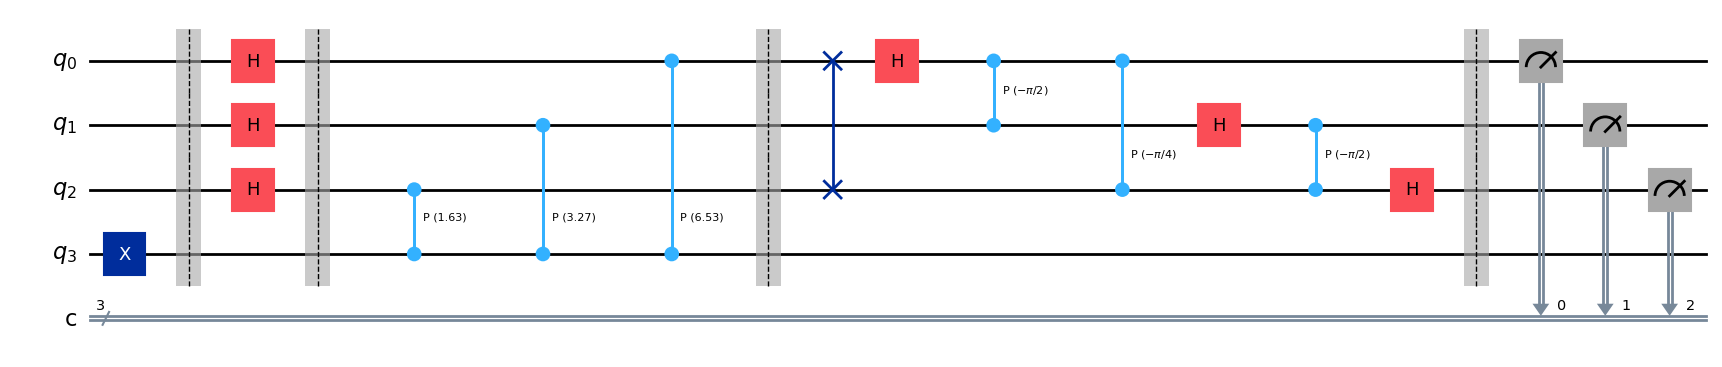

In [ ]:
# Parámetro de fase
theta = 0.26  # Esto es la fase que queremos estimar

# Cantidad de qubits
n_count = 3               # qubits de conteo (registro de fase)
target = 1                # qubit objetivo
total_qubits = n_count + target

# Crear circuito cuántico
qc = QuantumCircuit(total_qubits, n_count)

# Preparar el estado objetivo en |1⟩, que es un eigenvector de Rz
qc.x(n_count)  # Esto activa el qubit 3 si n_count=3 → índice 3

qc.barrier()

# 1. Hadamard en los qubits de conteo
for q in range(n_count):
    qc.h(q)

qc.barrier()

# 2. Aplicar U^{2^j} = Rz(2πθ * 2^j) con control
# U = Rz(2πθ), pero QPE requiere controlar U^{2^j} sobre cada qubit de conteo

for j in range(n_count):
    angle = 2 * pi * theta * (2**j)
    qc.cp(angle, n_count - 1 - j, n_count)  # control = qubit j (inverso), target = qubit objetivo

qc.barrier()

# 3. Aplicar QFT† inversa manual
# QFT inversa en qubits [0,1,2]

# Inversión de qubit por simetría
qc.swap(0, 2)

# Inversa de QFT en 3 qubits:
qc.h(0)
qc.cp(-pi/2, 0, 1)
qc.cp(-pi/4, 0, 2)
qc.h(1)
qc.cp(-pi/2, 1, 2)
qc.h(2)

qc.barrier()

# 4. Medición de los qubits de conteo
qc.measure(range(n_count), range(n_count))

qc.draw('mpl')

# **Ejecutando circuito**

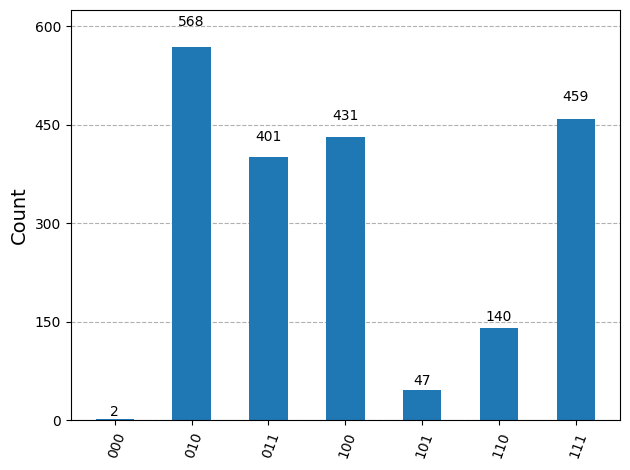

In [ ]:
from qiskit_aer import Aer # Simulador

# Definir el simulador 'aer_simulator','statevector_simulator','qasm_simulator','unitary_simulator'
backend = Aer.get_backend("statevector_simulator")

#Compilar y ejecutar el circuito en la computadora o simulador seleccionado el número de shots de 1024
compilado = transpile(circ, backend)
job = backend.run(compilado, shots=2048) #Ejecutar el circuito en la computadora o simulador seleccionado el número de shots dado
result = job.result() #Recupera los datos

counts = job.result().get_counts()
plot_histogram(counts)

# **Definir las funciones de las subrutinas para codificar la estimación de fase**

$\textbf{Funciones de inicialización}$

In [ ]:
def entradaBin(bin_ent,qc,qubits):
    for i in list(bin_ent):
        if i == '1':
            qc.x(qubits)
        qubits += 1

def inicializarCircuito(numeroQubits,funcion):
    bits = len(funcion) if len(funcion) > numeroQubits else numeroQubits
    circ = QuantumCircuit(numeroQubits+len(funcion),bits)
    for i in range(numeroQubits):
        circ.h(i)
    entradaBin(funcion,circ,numeroQubits)
    return circ

$\textbf{Definir la función para la estimación de fase para $n$ qubits}$

In [ ]:
def estimacion(numeroQubits,angulo,circ):
    for i in range(numeroQubits-1,-1,-1):
        circ.cp(2*pi*pow(2,i)*angulo,i,numeroQubits)

In [ ]:
from qiskit.circuit.library import QFTGate

def IQFT(circuit, n):
    circuit.append(QFTGate(n).inverse(), range(n))

In [ ]:
def obtenerFase(result):
    fases = []
    max_val = max(result.values())
    for key, val in result.items():
        if val == max_val:
            fase_decimal = int(key, 2) / 2**len(key)
            fases.append(fase_decimal)
    return fases

In [ ]:
def cambio(circuito, n):
    for j in range(n // 2):
        circuito.swap(j, n - j - 1)

$\textbf{Probar la transformación para 3 qubits para la fase $\theta =0.25$ y $\theta =0.3$}$

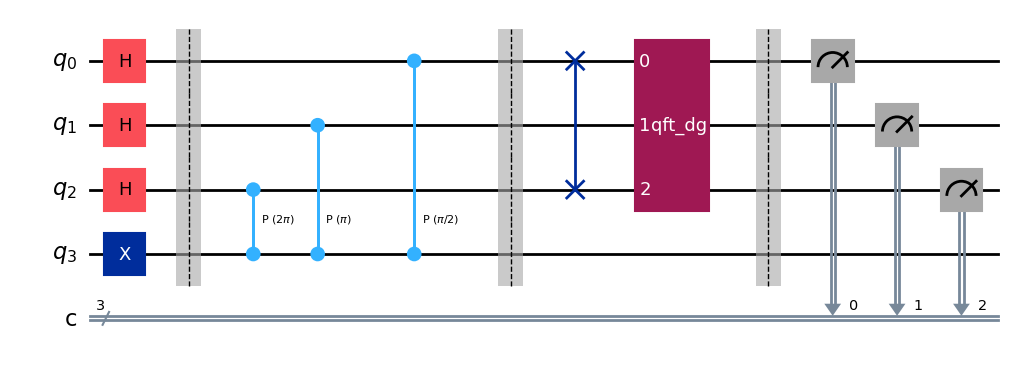

In [ ]:
angulo = 0.25
numeroQubits = 3
funcion = '1'

circ = inicializarCircuito(numeroQubits,funcion)
circ.barrier()
estimacion(numeroQubits,angulo,circ)
circ.barrier()
cambio(circ, numeroQubits)
IQFT(circ,numeroQubits)
circ.barrier()
circ.measure(range(numeroQubits), range(numeroQubits))
circ.draw('mpl')

{'101': 42, '001': 230, '110': 258, '111': 225, '011': 40, '010': 229}
[0.75]


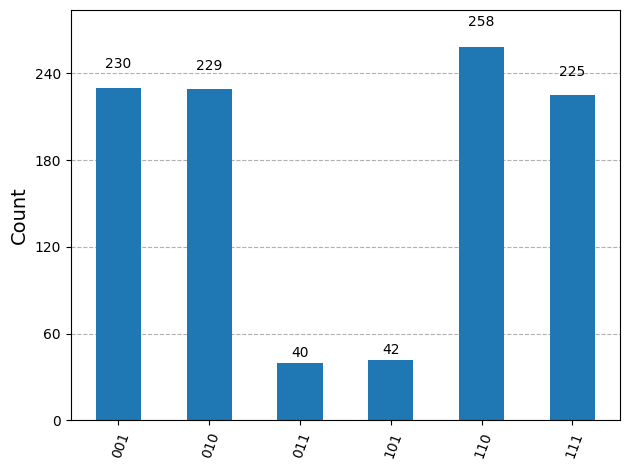

In [ ]:
backend = Aer.get_backend('statevector_simulator')
compilado = transpile(circ, backend)
job = backend.run(compilado, shots=1024)
result = job.result().get_counts()

print(result)
print(obtenerFase(result))

plot_histogram(result)

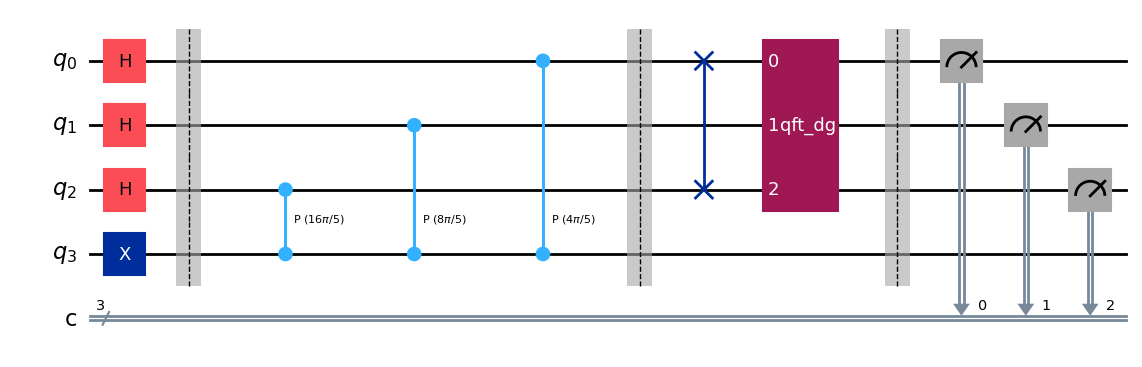

In [ ]:
angulo = 0.4
numeroQubits = 3
funcion = '1'
shots = 1024

circ = inicializarCircuito(numeroQubits,funcion)
circ.barrier()
estimacion(numeroQubits,angulo,circ)
circ.barrier()
cambio(circ, numeroQubits)
IQFT(circ,numeroQubits)
circ.barrier()
circ.measure(range(numeroQubits), range(numeroQubits))
circ.draw('mpl')

{'010': 5, '000': 10, '110': 24, '100': 53, '101': 22, '111': 384, '011': 526}
[0.375]


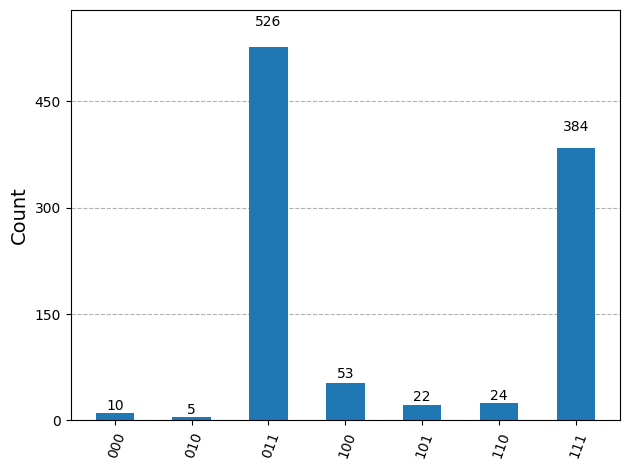

In [ ]:
backend = Aer.get_backend('aer_simulator')
compilado = transpile(circ, backend)
job = backend.run(compilado, shots=shots)
result = job.result().get_counts()
print(result)

print(obtenerFase(result))
plot_histogram(result)

In [ ]:
from math import pi

# --- Algoritmo QPE simplificado ---

def QPE(n_count, angle):
    # Circuito con n_count qubits para conteo + 1 para el eigenstate
    qc = QuantumCircuit(n_count + 1, n_count)

    # Preparo eigenstate (aquí |1>)
    qc.x(n_count)

    # Hadamards en registro de conteo
    for q in range(n_count):
        qc.h(q)

    # Aplicar U^{2^k} (aquí U = phase shift)
    for q in range(n_count):
        qc.cp(2*pi*angle*2**q, q, n_count)

    for q in range(n_count // 2):
        qc.swap(j, n_count - j - 1)

    # Inverse QFT
    qc.append(QFTGate(n_count).inverse(), range(n_count))

    # Medida
    qc.measure(range(n_count), range(n_count))

    return qc

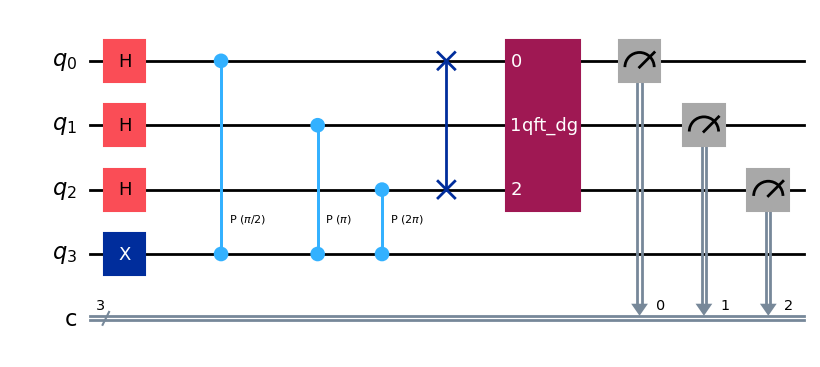

In [ ]:
# --- Prueba ---
angle = 0.25   # fase = 1/4 → debería salir 0.25 en binario
n_count = 3
qc = QPE(n_count, angle)
qc.draw('mpl')

{'101': 36, '010': 237, '110': 274, '011': 36, '111': 210, '001': 231}
[0.75]


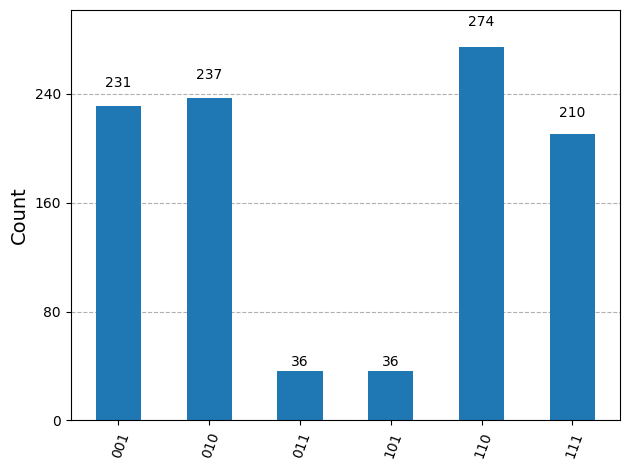

In [ ]:
backend = Aer.get_backend('statevector_simulator')
compilado = transpile(qc, backend)
job = backend.run(compilado, shots=1024)
result = job.result().get_counts()

print(result)
print(obtenerFase(result))

plot_histogram(result)